In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../code')

from utils import *
from rnnmodel import *
from tapdynamics import *
from particlefilter import *

In [2]:
"""
Load the tap brain model
"""
tapbrain = torch.load('../data/brains/Ns_5_noiseseed_0.pt')

use_cuda = True

if use_cuda and torch.cuda.is_available():
    tapbrain.cuda()
else:
    tapbrain.use_cuda = False

In [3]:
"""
Load required data
"""
with open('../data/brains/Ns_5_noiseseed_0_params.pkl','rb') as f:
    theta, params = pickle.load(f)
f.close()

In [4]:
"""
Extract model brain parameters
"""

Ns = params['Ns']
Ny = params['Ny']
Nr = params['Nr']
Q_process = params['Q_process']
Q_obs = params['Q_obs']
nltype = params['nltype']
gain_y = params['gain_y']
smoothing_filter = params['smoothing_filter']

lam, G, J, U, V = extractParams(theta, 18, Ns, Ny, Nr)

In [5]:
"""
Generate data
"""

B = 1  # No. of batches
T = 5000 # No. of time steps 
T_clip = 20

T_const = np.random.randint(2,20,size=(B))

y = np.zeros([Ny, T + T_clip, B])

# Initial values of latent dynamics
x0 = np.random.rand(Ns,B)

# Initialize arrays to save dynamics
x = np.zeros([Ns, T + T_clip + 1, B])
r = np.zeros([Nr, T + T_clip, B])

for bi in range(B):
    y[:,:,bi] = signal.filtfilt( smoothing_filter, 1, generateBroadH(Ny, T + T_clip, T_const[bi], gain_y) )
    x[:,:,bi], r[:,:,bi] = runTAP(x0[:,bi], y[:,:,bi], Q_process, Q_obs, theta, nltype)
    
y = torch.tensor(y.transpose(2,1,0), dtype=torch.float32) # input signal
r = torch.tensor(r.transpose(2,1,0), dtype=torch.float32) # target neural activity


print('No. of batches x T x No. of neurons')
print('Test data:', r.shape)

No. of batches x T x No. of neurons
Test data: torch.Size([1, 5020, 10])


In [6]:
"""
Run model on test data
"""
if use_cuda and torch.cuda.is_available():
    y = y.cuda()

r_brain = tapbrain(y)[0]

y    = y[:,T_clip:].cpu().data.numpy()
r    = r[:,T_clip:].cpu().data.numpy()
r_brain = r_brain[:,T_clip:].cpu().data.numpy()

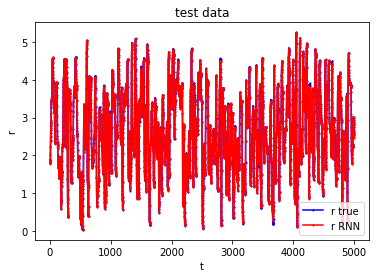

In [7]:
"""
Test data
"""
plt.plot(r[0,:,0],'b.-',markersize=2)
plt.plot(r_brain[0,:,0],'r.-',markersize=2)
plt.xlabel('t')
plt.ylabel('r')
plt.title('test data')
plt.legend(['r true', 'r RNN'])
plt.show()

In [8]:
"""
Reshape the data variables
"""
y = y.transpose(2,1,0)
r = r.transpose(2,1,0)
r_brain = r_brain.transpose(2,1,0)

x = x[:,T_clip:]

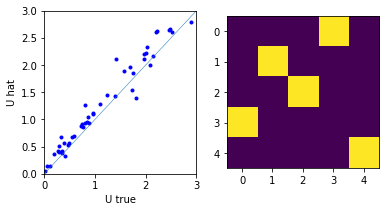

In [11]:
"""
Use ICA to get initial estimate of the embedding
"""

U_hat = UhatICA(np.reshape(r_brain,[Nr,T*B],order='F').T, Ns)[0]

# Estimate the permutation matrix P (need this to resolve permutation ambiguity of ICA)
PermMat = EstimatePermutation_ICA(U,U_hat)

# Plot estimate of embedding and permutation matrix
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_hat,PermMat).flatten(),'b.')
umax = np.ceil(np.max(np.abs(U)))
ax[0].plot([0,umax],[0,umax],Linewidth=0.5)
ax[0].axis([0,umax,0,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[1].imshow(PermMat)
plt.show()

In [12]:
"""
Pick only a subset of the data. 
We used a lot more data to obtain the initial estimate of the embedding using ICA. 
We will use a subset of the data for the  PF - EM
"""

TTotal = 500 # Total no. of time steps to use for analysis
T = TTotal//B

# Retain only the required subset of data
r = r[:,0:T,:]
y = y[:,0:T,:]
x = x[:,0:T+1,:]
r_brain = r_brain[:,0:T,:]

In [13]:
"""
Run the particle filter with true values of (G, J, U, V)
"""

Q_process = 1e-5*np.eye(Ns)    # measurement noise
Q_obs     = 5e-4*np.eye(Nr)    # measurement noise
Np = 100                       # No. of particles

x_tp = np.zeros([Ns,T+1,B])    # decoded latent dynamics using ground truth parameters (tp)
P_tp = np.zeros([Ns,Np,T+1,B]) # dynamics of individual particles
r_tp = np.zeros([Nr,T,B])      # fit to measurements using ground truth parameters
W_tp = np.zeros([Np,B])        # weights of each particles

LL_tp = np.zeros([B])          # data log-likelihood

for bi in range(B):
    LL_tp[bi], x_tp[:,:,bi], P_tp[:,:,:,bi], W_tp[:,bi] = particlefilter(r_brain[:,:,bi], y[:,:,bi], Np, Q_process, Q_obs, theta, nltype)
    r_tp[:,:,bi] = np.dot(U,x_tp[:,1:,bi])

print('Log likelihood with true params = ', LL_tp.mean())

Log likelihood with true params =  -3233.3533466406097


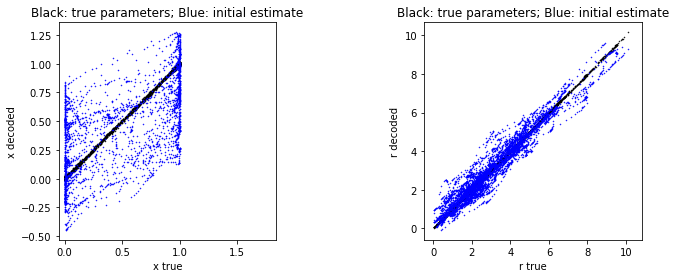

Log likelihood pre PF-EM =  -144799.82930744867


In [14]:
"""
Initialize the parameters for PF-EM
"""

lam_hat = np.array([lam])                       

G_hat = 0.1*np.random.randn(18)           
J_hat = Create_J(Ns, params['sparsity_J'], 'nonferr', params['self_coupling_on']) 
V_hat = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]

# Initialize the arrays for latent dynamics, fits to meausurements, particles, 
# particle weights and data log-likelihoods obtained using current values of the parameters

x_hat = np.zeros([Ns,T+1,B])
r_hat = np.zeros([Nr,T,B])
P_hat = np.zeros([Ns,Np,T+1,B])
W_hat = np.zeros([Np,B])
LL_hat = np.zeros([B])


theta_hat = np.concatenate([lam_hat, G_hat, JMatToVec(J_hat), U_hat.flatten('F'), V_hat.flatten('F') ])

# Run the PF using initial eLL_Vecimates of the parameters
for bi in range(B):
    LL_hat[bi],x_hat[:,:,bi], P_hat[:,:,:,bi], W_hat[:,bi] = particlefilter(r_brain[:,:,bi], y[:,:,bi], Np, Q_process, Q_obs, theta_hat, nltype)
    r_hat[:,:,bi] = np.dot(U_hat, x_hat[:,1:,bi])
    

T_st = 6 # discard the first T_st samples for plotting

# Plot comparison of latent states decoded by the PF using initial value of parameters vs. ground truth
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x[:,T_st:,:].flatten(), x_tp[:,T_st:,:].flatten(),'k.',markersize=1)
ax[0].plot(x[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_hat[:,T_st:,:],[Ns,B*(T+1-T_st)])).flatten(),'b.',markersize=1)
ax[0].set(xlabel='x true', ylabel='x decoded')
ax[0].set_title('Black: true parameters; Blue: initial estimate')
ax[0].axis('square')

ax[1].plot(r_brain[:,T_st:,:].flatten(),r_tp[:,T_st:,:].flatten(),'k.',markersize=1)
ax[1].plot(r_brain[:,T_st:,:].flatten(),r_hat[:,T_st:,:].flatten(),'b.',markersize=1)
ax[1].set(xlabel='r true', ylabel='r decoded')
ax[1].set_title('Black: true parameters; Blue: initial estimate')
ax[1].axis('square')
plt.show()



# Record the initial values of the required parameters and arrays
x_init = x_hat*1.0
r_init = r_hat*1.0

J_init = J_hat*1.0
G_init = G_hat*1.0
U_init = U_hat*1.0
V_init = V_hat*1.0
lam_init = lam_hat*1.0

#del x_tp, r_truedec, P_truedec, W_truedec

print('Log likelihood pre PF-EM = ',LL_hat.mean())

In [18]:
"""
Run the particle EM algorithm
"""

# Run the PF-EM on mini-batches of the entire dataset. Each batch comprises a subset of sessions. 
# For now, each mini-batch comprises just one individual session.

# Coefficient of L1 sparsity constraints for learning J and G
alpha_J = 0
alpha_G = 0

idx     = np.random.randint(B)
r_b     = r_brain[:,:,idx]      # pick the observations for the mini batch
y_b     = y[:,:,idx]            # pick the input signals for the mini batch 
P_b     = P_hat[:,:,:,idx]
W_b     = W_hat[:,idx]

EMIters = 40                 # maximum no. of iterations to use for the EM algorithm
MStepMaxIter = 10             # Maximum no. of iterations used by the optimizer in the M step
LL_Vec   = np.zeros([EMIters]) # record how the log-likelihood changes with iterations

computegrad = np.array([1,1,0,1,0],dtype=int) # Flags which indicate which variables are updated in the order: G, J, U, V, lam

# We keep the Uhat fixed for the first 20% of EM iterations and update the rest. After that, we update all the parameters together.
# Right now, I am just running the EM algorithm for EMIters no. of iterations.

for iterem in range(EMIters):
    
    if iterem == EMIters//5:
        computegrad = [1, 1, 1, 1, 0]

    if iterem % 20 == 19:
        print('iterem =', iterem + 1)  
    
    MStep = optimize.minimize(NegLL, theta_hat, args = (r_b, y_b, P_b, W_b, Q_process, Q_obs, nltype, computegrad, alpha_J, alpha_G), method='BFGS', jac = NegLL_D, options={'disp': False,'maxiter':MStepMaxIter})
    theta_hat = MStep.x
        
    # E step: Pick a new batch and run the particle filter with the updated parameters    
    idx     = np.random.randint(B)
    r_b     = r_brain[:,:,idx] 
    y_b     = y[:,:,idx]
    
    LL_Vec[iterem], x_b, P_b, W_b = particlefilter(r_b, y_b, Np, Q_process, Q_obs, theta_hat, nltype)
    

iterem = 20
iterem = 40


In [19]:
"""
Run the PF on all batches with new parameters
"""
# Extract parameters
lam_hat, G_hat, J_hat, U_hat, V_hat = extractParams(theta_hat, 18, Ns, Ny, Nr)

# Run the PF with new parameters on all the batches
for bi in range(B):
    LL_hat[bi], x_hat[:,:,bi], P_hat[:,:,:,bi], W_hat[:,bi] = particlefilter(r_brain[:,:,bi], y[:,:,bi], Np, Q_process, Q_obs, theta_hat, nltype)
    r_hat[:,:,bi] = np.dot(U_hat, x_hat[:,1:,bi])
    
print('Log likelihood post PF-EM = ', LL_hat.mean())

Log likelihood post PF-EM =  -3121.5644791089803


Ghat = [ 0.4765635   0.61365536  0.34645014  0.03911311  0.10734903 -0.00149542
  0.01522792  0.09632026  0.04496355  0.1646953  -0.08845511 -0.01148722
 -0.16620789 -0.13261596 -0.07980832 -0.11881367 -0.15699581 -0.14171488]


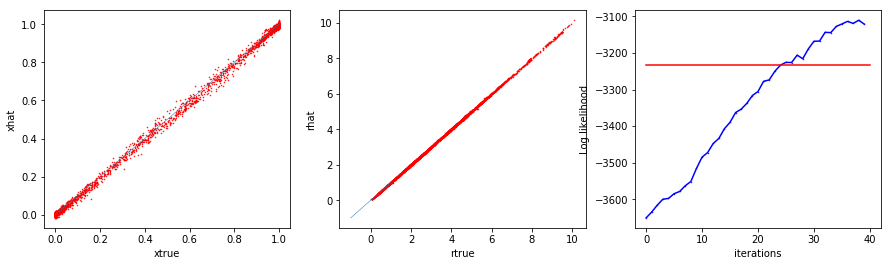

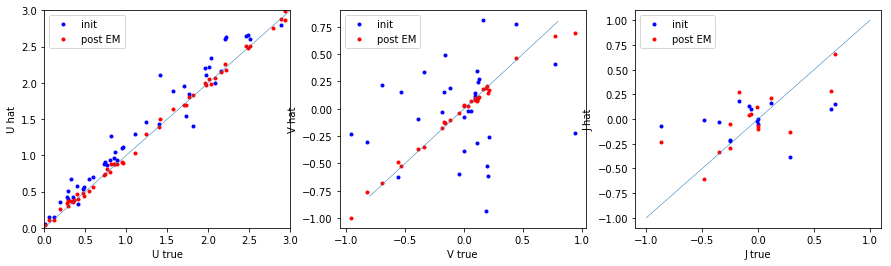

In [20]:
"""
Plotting results
"""

# Figure 1
print('Ghat =', G_hat)

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].plot(x[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_hat[:,T_st:,:],[Ns,B*(T+1-T_st)])).flatten(),'r.',markersize=1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='xtrue', ylabel='xhat')
ax[1].plot(r_brain[:,T_st:,:].flatten(),r_hat[:,T_st:,:].flatten(),'r.',markersize=1)
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].set(xlabel='rtrue', ylabel='rhat')
ax[2].plot(np.arange(EMIters),LL_Vec,'b.-',markersize=1)
ax[2].plot([0,EMIters],[LL_tp.mean(), LL_tp.mean()],'r')
ax[2].set(xlabel='iterations', ylabel='Log likelihood')
plt.show()

# Figure 2

Jhat = J_hat*0
Jinit = J_init*0 # shuffle Jinit also
x_idx = np.dot(PermMat.T, np.arange(Ns))

for ii in range(Ns):
    for jj in range(Ns):
        Jhat[ii,jj] = J_hat[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit[ii,jj] = J_init[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].plot(U.flatten(),np.dot(U_init,PermMat).flatten(),'b.')
ax[0].plot(U.flatten(),np.dot(U_hat,PermMat).flatten(),'r.')
ax[0].plot([0,umax],[0,umax],Linewidth=0.5)
ax[0].axis([0,umax,0,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.flatten(),np.dot(PermMat.T, V_init).flatten(),'b.')
ax[1].plot(V.flatten(),np.dot(PermMat.T, V_hat).flatten(),'r.')
ax[1].plot([-.8,.8],[-.8,.8],linewidth=0.5)
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec(J),JMatToVec(Jinit),'b.')
ax[2].plot(JMatToVec(J),JMatToVec(Jhat),'r.')
ax[2].plot([-1,1],[-1,1],linewidth=0.5)
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
plt.show()

In [18]:
x_hat.shape

(5, 501, 1)